<a href="https://colab.research.google.com/github/tonysf/tonysf.github.io/blob/master/modula_in_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modula in NumPy!

 <div> </div>



The notebook implements Modula in NumPy. Why would anyone do such a thing? A few reasons:

1.   Pure NumPy ensures there is no "magic" happening anywhere.
2.   Bare-bones code will hopefully be easier to understand and extend.
3.   It's a fun intellectual exercise to see how far we can push the module abstraction.

We built the notebook in the following order:
- <ins>Day one</ins>: implement `Module.forward` and `Module.initialize`. Build an MLP.
- <ins>Day two</ins>: implement `Module.backward` to be able to autodiff the MLP.
- <ins>Day three</ins>: implement `Module.normalize` and start on `TupleModule`.
- <ins>Day four</ins>: finish `TupleModule`. Build a residual-MLP.
- <ins>Day five</ins>: implement mass taring. Test learning rate transfer.
- <ins>Day six</ins>: refactor all module methods into pure functions (modules don't store activations or weights).

Each session lasted an hour to an hour and a half with some bug fixes after the session (the bugs we ran into are recorded at the bottom). Thanks to [ScaleML](https://atlas-mlc.github.io/) for hosting, and the following participants in the sessions:
- Tony Silveti-Falls
- Mark Jimenez
- Jyo Pari
- Han Guo
- Lars Ankile
- Adrian Rodriguez-Muñoz
- William Brandon
- Lucas Torroba Hennigen

If you're looking for a fun extension project, consider:
1. In `Linear.normalize` and `ShampooLinear.normalize`, the notebook uses `np.linalg.norm` and `np.linalg.svd` for simplicity. But these functions are *slow*. Can you speed up the normalization by implementing approximate versions of these methods?
1. Modula x JAX. Try switching `import numpy as np` over to `import jax.numpy as np`. What else do you need to change to get this working? *Hint: look up how JAX handles randomness.* Once you fix this, you should be able to apply `jax.jit` to your top-level `Module.forward` and `Module.backward` methods to make them fast. Also check out the [Modulax project](https://github.com/GallagherCommaJack/modulax/) for more inspiration.
2. Modula x nanoGPT. Implement a nanoGPT in pure NumPy! For help, you might want to borrow the dataloading code from Karpathy's [nanoGPT repo](https://github.com/karpathy/nanoGPT). Start with the Shakespeare data. It would also help to look at how we implement GPT in the [Modula PyTorch repo](https://github.com/jxbz/modula/blob/main/modula/compound.py). In particular, you'd need to write your own `FunctionalAttention` and `Embedding` modules.
3. Implement your own `Module.regularize` methods. We haven't explored this aspect much ourselves yet, and there's a big potential design space here. [This paper](https://arxiv.org/abs/2406.06811) might give you some inspiration.

## Abstract module functionality

In [ ]:
class Module:
    def __init__(self):
        self.children = []

        self.atoms = None           # number of atoms: int
        self.bonds = None           # number of bonds: int
        self.smooth = None          # is this module smooth?: bool
        self.sensitivity = None     # input Lipschitz estimate: float > 0
        self.mass = None            # proportional contribution of module toward feature learning of any supermodule: float >= 0

    def __str__(self):
        string = self.__class__.__name__
        string += f"\n...consists of {self.atoms} atoms and {self.bonds} bonds"
        string += f"\n...{'smooth' if self.smooth else 'non-smooth'}"
        string += f"\n...input sensitivity is {self.sensitivity}"
        string += f"\n...contributes proportion {self.mass} to feature learning of any supermodule"
        return string

    def tare(self, absolute=1.0, relative=None):
        if relative is None:
            self.tare(relative = absolute / self.mass)
        else:
            self.mass *= relative
            for m in self.children:
                m.tare(relative = relative)

    def forward(self, x, w):
        # Input and weight list --> output and list of internal activations.
        raise NotImplementedError

    def backward(self, w, grad_output):
        # Weight list and output gradient --> weight gradient list and input gradient.
        raise NotImplementedError

    def initialize(self):
        # Return a weight list.
        raise NotImplementedError

    def normalize(self, grad_w, target_norm):
        # Weight gradient list and number --> normalized weight gradient list
        raise NotImplementedError

    def __matmul__(self, other):
        return CompositeModule(self, other)

    def __add__(self, other):
        return Add() @ TupleModule((self, other))

    def __rmul__(self, scalar):
        return Mul(scalar) @ self

    def __call__(self, x, w):
        return self.forward(x, w)

class Atom(Module):
    def __init__(self):
        super().__init__()
        self.atoms = 1
        self.bonds = 0

class Bond(Module):
    def __init__(self):
        super().__init__()
        self.atoms = 0
        self.bonds = 1
        self.mass = 0

    def initialize(self):
        return []

    def normalize(self, grad_w, target_norm=1.0):
        return []

class CompositeModule(Module):
    def __init__(self, m1, m0):
        super().__init__()
        self.children = (m0, m1)

        self.atoms       = m0.atoms + m1.atoms
        self.bonds       = m0.bonds + m1.bonds
        self.smooth      = m0.smooth and m1.smooth
        self.mass        = m0.mass + m1.mass
        self.sensitivity = m0.sensitivity * m1.sensitivity

    def forward(self, x, w):
        m0, m1 = self.children
        w0 = w[:m0.atoms]
        w1 = w[m0.atoms:]
        x0, activations0 = m0.forward(x, w0)
        x1, activations1 = m1.forward(x0, w1)
        return x1, activations0 + activations1

    def initialize(self):
        m0, m1 = self.children
        return m0.initialize() + m1.initialize()

    def backward(self, w, acts, grad_output):
        m0, m1 = self.children
        w0 = w[:m0.atoms]
        w1 = w[m0.atoms:]
        acts0 = acts[:m0.atoms+m0.bonds]
        acts1 = acts[m0.atoms+m0.bonds:]

        grad_w1, grad_input1 = m1.backward(w1, acts1, grad_output)
        grad_w0, grad_input0 = m0.backward(w0, acts0, grad_input1)

        return grad_w0 + grad_w1, grad_input0

    def normalize(self, grad_w, target_norm=1.0):
        if self.mass > 0:
            m0, m1 = self.children
            grad_w0, grad_w1 = grad_w[:m0.atoms], grad_w[m0.atoms:]
            grad_w0 = m0.normalize(grad_w0, target_norm = target_norm * m0.mass / self.mass / m1.sensitivity)
            grad_w1 = m1.normalize(grad_w1, target_norm = target_norm * m1.mass / self.mass)
            normalized_grad_w = grad_w0 + grad_w1
        else:
            normalized_grad_w = [0 * grad_weight for grad_weight in grad_w]
        return normalized_grad_w

class TupleModule(Module):
    def __init__(self, python_tuple_of_modules):
        super().__init__()
        self.children = python_tuple_of_modules
        self.atoms       = sum(m.atoms       for m in self.children)
        self.bonds       = sum(m.bonds       for m in self.children)
        self.smooth      = all(m.smooth      for m in self.children)
        self.mass        = sum(m.mass        for m in self.children)
        self.sensitivity = sum(m.sensitivity for m in self.children)

    def forward(self, x, w):
        output_list = []
        act_list = []
        for m in self.children:
            output, act = m.forward(x, w[:m.atoms])
            output_list.append(output)
            act_list += act
            w = w[m.atoms:]
        return output_list, act_list

    def backward(self, w, acts, grad_output):
        grad_w = []
        grad_input = 0
        for m, grad_output_m in zip(self.children, grad_output):
            grad_w_m, grad_input_m = m.backward(w[:m.atoms], acts[:m.atoms+m.bonds], grad_output_m)
            grad_w += grad_w_m
            grad_input += grad_input_m
            w = w[m.atoms:]
            acts = acts[m.atoms+m.bonds:]
        return grad_w, grad_input

    def initialize(self):
        return sum([m.initialize() for m in self.children], [])

    def normalize(self, grad_w, target_norm=1.0):
        if self.mass > 0:
            normalized_grad_w = []
            for m in self.children:
                grad_w_m = grad_w[:m.atoms]
                grad_w_m = m.normalize(grad_w_m, target_norm = target_norm * m.mass / self.mass)
                normalized_grad_w += grad_w_m
                grad_w = grad_w[m.atoms:]
        else:
            normalized_grad_w = [0 * grad_weight for grad_weight in grad_w]
        return normalized_grad_w

class Identity(Bond):
    def __init__(self):
        super().__init__()
        self.smooth = True
        self.sensitivity = 1

    def forward(self, x, w):
        return x, [None]

    def backward(self, w, acts, grad_output):
        return [], grad_output

class Add(Bond):
    def __init__(self):
        super().__init__()
        self.smooth = True
        self.sensitivity = 1

    def forward(self, x, w):
        return sum(x), [None]

    def backward(self, w, acts, grad_output):
        return [], (grad_output, grad_output)

class Mul(Bond):
    def __init__(self, scalar):
        super().__init__()
        self.smooth = True
        self.sensitivity = scalar

    def forward(self, x, w):
        return x * self.sensitivity, [None]

    def backward(self, w, acts, grad_output):
        return [], grad_output * self.sensitivity


## Atomic modules

In [ ]:
import numpy as np

class Linear(Atom):
    def __init__(self, fanout, fanin):
        super().__init__()
        self.fanin  = fanin
        self.fanout = fanout
        self.smooth = True
        self.scale = np.sqrt(self.fanout / self.fanin)
        self.mass = 1
        self.sensitivity = 1

    def forward(self, x, w):
        weights = w[0]
        return self.scale * weights @ x, [x]

    def backward(self, w, acts, grad_output):
        weights = w[0]
        input = acts[0]
        grad_input = self.scale * weights.T @ grad_output                         # oops: self.scale appears here
        grad_weight = self.scale * grad_output @ input.T                          # oops: self.scale appears here
        return [grad_weight], grad_input

    def initialize(self):
        # semi-orthogonal init
        A = np.random.normal(size=(self.fanout, self.fanin))
        A = A if self.fanout > self.fanin else A.T
        Q = np.linalg.qr(A, mode='reduced')[0]
        Q = Q if self.fanout > self.fanin else Q.T
        return [Q]

    def normalize(self, grad_w, target_norm=1.0):
        grad_weight = grad_w[0]
        spectral_norm = np.linalg.norm(grad_weight, ord=2)
        return [grad_weight / spectral_norm * target_norm]

class ShampooLinear(Linear):
    def __init__(self, fanout, fanin):
        super().__init__(fanout, fanin)

    def normalize(self, grad_w, target_norm=1.0):
        grad_weight = grad_w[0]
        U, S, Vt = np.linalg.svd(grad_weight, full_matrices=False)
        return [U @ Vt * target_norm]

class ReLU(Bond):
    def __init__(self):
        super().__init__()
        self.smooth = False
        self.sensitivity = 1

    def forward(self, x, w):
        return np.maximum(0, x), [x]

    def backward(self, w, acts, grad_output):
        input = acts[0]
        grad_input = (input > 0) * grad_output
        return [], grad_input


## Error functions

In [ ]:
class Error:

    def value(self, output, target):
        raise NotImplementedError

    def grad(self, output, target):
        raise NotImplementedError

    def __call__(self, output, target):
        return self.value(output, target)

class SquareError(Error):

    def __init__(self):
        super().__init__()

    def value(self, output, target):
        return ((output-target) ** 2).mean()

    def grad(self, output, target):
        return 2 * (output - target) / output.size

class XentError(Error):

    def __init__(self):
        super().__init__()

    def value(self, output, target):
        raise NotImplementedError

    def grad(self, output, target):
        raise NotImplementedError


## Let's write a training loop

In [ ]:
def train(module, error, input, target, steps, init_lr, normalize, tqdm=False):
    train_loss_list = []
    w = module.initialize()

    if tqdm:
        from tqdm.notebook import tqdm
    else:
        tqdm = lambda x: x

    for step in tqdm(range(steps)):
        schedule = 1 - step / steps

        output, activations = module(input, w)
        loss = error(output, target)
        error_grad = error.grad(output, target)
        grad_w, _ = module.backward(w, activations, error_grad)
        if normalize:
            grad_w = module.normalize(grad_w)

        for weight, grad_weight in zip(w, grad_w):
            weight -= init_lr * schedule * grad_weight

        train_loss_list.append(loss)

    return train_loss_list


## Let's train an MLP

In [ ]:
input_dim = 11
width = 100
output_dim = 6
batch_size = 32
steps = 1001
lr_list = 10.0 ** np.arange(-4, 1)

error = SquareError()

x = np.random.rand(input_dim, batch_size)
y = np.random.rand(output_dim, batch_size)

results = {}
config_list = [(False, False), (True, False), (True, True)]

for normalize, shampoo in config_list:

    print("running config:", "normalize", normalize, "shampoo", shampoo)
    for init_lr in lr_list:
        print("init_lr", init_lr)

        M = ShampooLinear if shampoo else Linear
        m = M(output_dim, width) @ ReLU() @ M(width, input_dim)

        results[(normalize, shampoo, init_lr)] = train(m, error, x, y, steps, init_lr, normalize)


running config: normalize False shampoo False
init_lr 0.0001
init_lr 0.001
init_lr 0.01
init_lr 0.1
init_lr 1.0
running config: normalize True shampoo False
init_lr 0.0001
init_lr 0.001
init_lr 0.01
init_lr 0.1
init_lr 1.0
running config: normalize True shampoo True
init_lr 0.0001
init_lr 0.001
init_lr 0.01
init_lr 0.1
init_lr 1.0


## Plot the results

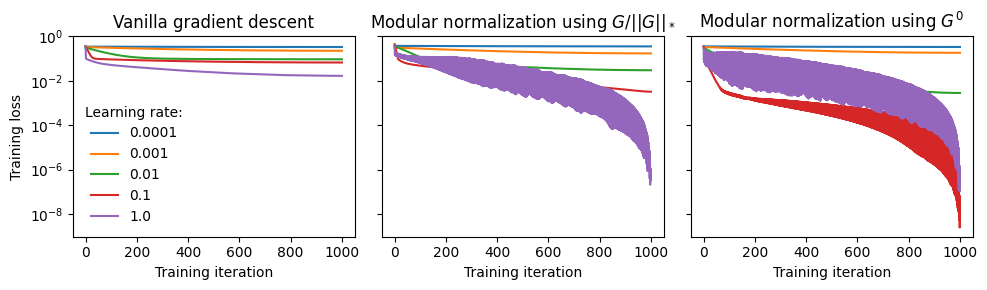

In [ ]:
import matplotlib.pyplot as plt

config_titles = ["Vanilla gradient descent", "Modular normalization using $G/||G||_*$", "Modular normalization using $G^0$"]

fig, ax = plt.subplots(1, len(config_list), figsize=(10, 3), sharey=True)

for i, (normalize, shampoo) in enumerate(config_list):
    for init_lr in lr_list:
        ax[i].plot(results[(normalize, shampoo, init_lr)], label=init_lr)
    ax[i].set_title(config_titles[i])
    ax[i].set_xlabel("Training iteration")
    ax[i].set_yscale("log")

ax[0].set_ylabel("Training loss")
ax[0].legend(title="Learning rate:", frameon=False)
ax[0].set_ylim(None, 1)

plt.tight_layout()
plt.show()


## Now let's test learning rate transfer across width

In [ ]:
input_dim = 11
width_list = [8, 16, 32, 64, 128, 256, 512]
output_dim = 6
batch_size = 32
steps = 1001
error = SquareError()

x = np.random.rand(input_dim, batch_size)
y = np.random.rand(output_dim, batch_size)

results = {}

for normalize, shampoo in config_list:
    print("running config:", "normalize", normalize, "shampoo", shampoo)

    if normalize:
        lr_list = 1.41 ** np.arange(-16, 4)
    else:
        shift_right = 8
        lr_list = 1.41 ** np.arange(-16 + shift_right, 4 + shift_right)

    for width in width_list:
        print("sweeping over learning rates at width", width)

        for init_lr in lr_list:
            M = ShampooLinear if shampoo else Linear
            m = M(output_dim, width) @ ReLU() @ M(width, input_dim)

            results[(normalize, shampoo, width, init_lr)] = train(m, error, x, y, steps, init_lr, normalize)

running config: normalize False shampoo False
sweeping over learning rates at width 8
sweeping over learning rates at width 16
sweeping over learning rates at width 32
sweeping over learning rates at width 64
sweeping over learning rates at width 128
sweeping over learning rates at width 256
sweeping over learning rates at width 512
running config: normalize True shampoo False
sweeping over learning rates at width 8
sweeping over learning rates at width 16
sweeping over learning rates at width 32
sweeping over learning rates at width 64
sweeping over learning rates at width 128
sweeping over learning rates at width 256
sweeping over learning rates at width 512
running config: normalize True shampoo True
sweeping over learning rates at width 8
sweeping over learning rates at width 16
sweeping over learning rates at width 32
sweeping over learning rates at width 64
sweeping over learning rates at width 128
sweeping over learning rates at width 256
sweeping over learning rates at width 51

## Plot the results

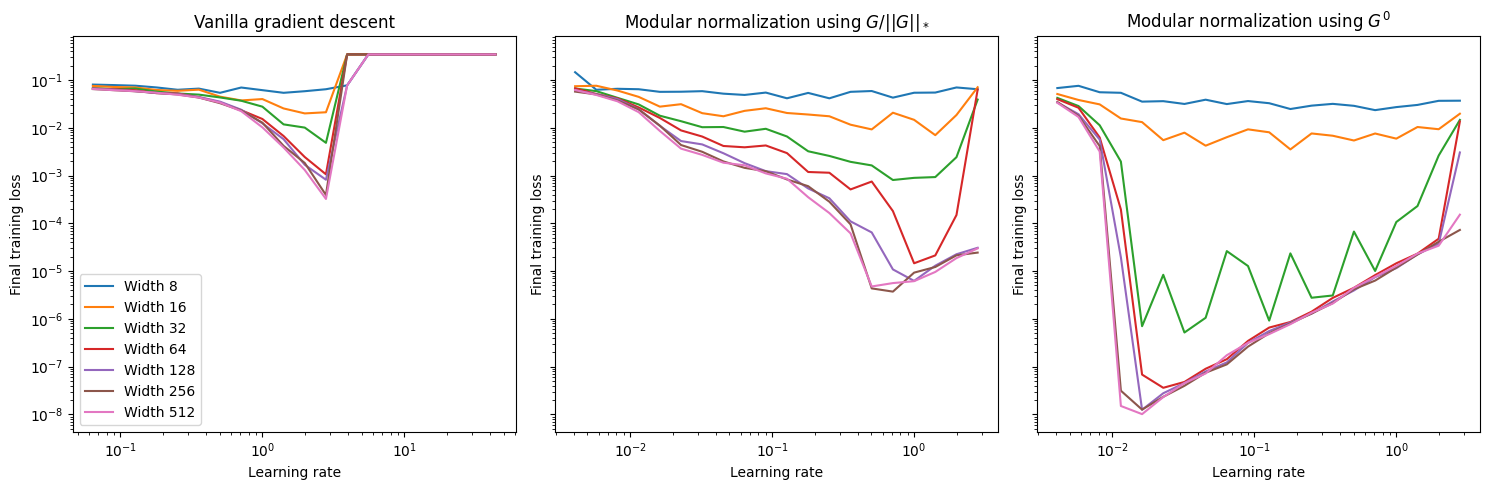

In [ ]:
fig, ax = plt.subplots(1, len(config_list), figsize=(15, 5), sharey=True)

for i, (normalize, shampoo) in enumerate(config_list):

    if normalize:
        lr_list = 1.41 ** np.arange(-16, 4)
    else:
        shift_right = 8
        lr_list = 1.41 ** np.arange(-16 + shift_right, 4 + shift_right)

    for width in width_list:
        final_losses = [np.mean(results[(normalize, shampoo, width, init_lr)][-20:]) for init_lr in lr_list]
        ax[i].plot(lr_list, final_losses, label=f"Width {width}")

    ax[i].set_title(config_titles[i])
    ax[i].set_xlabel("Learning rate")
    ax[i].set_ylabel("Final training loss")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
ax[0].legend()

plt.tight_layout()
plt.show()

## Let's train a ResMLP

In [ ]:
input_dim = 11
width = 100
output_dim = 6
batch_size = 32
steps = 1001
init_lr = 0.5
normalize = True
shampoo = True
depth = 4
error = SquareError()

M = ShampooLinear if shampoo else Linear

output_module = M(output_dim, width)
input_module  = M(width, input_dim)

blocks = Identity()
for _ in range(depth):
    block = ((depth-1)/depth * Identity()) + (1/depth * M(width, width) @ ReLU() @ M(width, width))
    blocks @= block
blocks.tare(absolute = 1)

m = output_module @ blocks @ input_module
print(m)

x = np.random.rand(input_dim, batch_size)
y = np.random.rand(output_dim, batch_size)

train_loss_list = train(m, error, x, y, steps, init_lr, normalize, tqdm=True)

print("Final loss", train_loss_list[-1])

CompositeModule
...consists of 10 atoms and 21 bonds
...non-smooth
...input sensitivity is 1.0
...contributes proportion 3.0 to feature learning of any supermodule


  0%|          | 0/1001 [00:00<?, ?it/s]

Final loss 8.764889140906332e-09


## Unit tests

In [ ]:
input_dim = 11
width = 20
output_dim = 6
batch_size = 32

m2 = Linear(output_dim, width)
m1 = Linear(width, input_dim)
relu = ReLU()

m = m2 @ relu @ m1
w = m.initialize()

x = np.random.rand(input_dim, batch_size)
y = np.random.rand(output_dim, batch_size)

error = SquareError()

# first, let's check that forward pass works via a direct calculation
output, activations = m(x, w)
output_direct_calculation = np.sqrt(output_dim / width) * w[1] @ np.maximum(0, np.sqrt(width / input_dim) * w[0] @ x)
print("Forward pass check:", np.allclose(output, output_direct_calculation))

# second, let's check that backward pass works by comparing to finite differences
loss = error(output, y)
grad_loss = error.grad(output, y)
grad_w, _ = m.backward(w, activations, grad_loss)

delta_w = [0.00000001 * np.random.normal(size=weight.shape) for weight in w]
new_w = [weight + delta for weight, delta in zip(w, delta_w)]
new_output, new_activations = m(x, new_w)
new_loss = error(new_output, y)

linearized_loss = loss + sum([(delta * grad).sum() for delta, grad in zip(delta_w, grad_w)])
print("Backward pass check:", np.allclose(new_loss, linearized_loss))
print("...orig_loss\t", loss)
print("...new_loss\t", new_loss)
print("...lin_loss\t", linearized_loss)

Forward pass check: True
Backward pass check: True
...orig_loss	 0.3283979317111466
...new_loss	 0.3283979306204056
...lin_loss	 0.32839793062040523


## Main bugs we ran into

1. Currently need to manually differentiate the loss with respect to network outputs. Make sure to do that correctly!

2. If the forward function contains explicit scalar multipliers, they should appear in the backward function too.

3. Don't trust Colab autocomplete with your life.

## Scratch space

In [ ]:
a = [1,2,3]
b = [1,2,3]
c = [a,b]
print(c)
sum(c, [])

[[1, 2, 3], [1, 2, 3]]


[1, 2, 3, 1, 2, 3]